In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import ParameterGrid
from time import time
import tensorflow as tf


# Crop yield dataset

In [2]:
df = pd.read_csv("C:/Users/laura/OneDrive/Documents/GitHub/AISE_Group9/crop_yield_dataset.csv")
df = df.set_index('Date')
df.drop("Crop_Type",axis=1,inplace=True)
wheat = df.iloc[::10].copy()
corn = df.iloc[1::10].copy()
rice = df.iloc[2::10].copy()
barley = df.iloc[3::10].copy()
soybean = df.iloc[4::10].copy()
cotton = df.iloc[5::10].copy()
sugarcane = df.iloc[6::10].copy()
tomato = df.iloc[7::10].copy()
potato = df.iloc[8::10].copy()
sunflower = df.iloc[9::10].copy()



In [67]:
crop = "tomato"
series = tomato[["Crop_Yield","Temperature","Humidity"]]

In [68]:
series.head()

,Crop_Yield,Temperature,Humidity
Date,,,
2014-01-01,22.221375,18.323272,80.0
2014-01-02,31.009611,19.877726,80.0
2014-01-03,19.466158,17.304778,80.0
2014-01-04,1.864858,15.384475,80.0
2014-01-05,0.000000,5.327149,80.0


In [69]:
# univariate data splitting
X = series.drop("Crop_Yield",axis=1)
y = series["Crop_Yield"]
test_split = round(len(series)*0.8)
train_set = series[0:test_split]
test_set = series[test_split:]

In [70]:
scaler = MinMaxScaler()
train_set_sc = scaler.fit_transform(train_set)
test_set_sc= scaler.transform(test_set)


In [71]:
def createXY(dataset,time_step):
    dataX = []
    dataY = []
    for i in range(len(dataset)-time_step):
            dataX.append(dataset[i:i + time_step][:,0:2])
            dataY.append(dataset[i + time_step][0])
    return np.array(dataX),np.array(dataY)


In [72]:
X_train, y_train=createXY(train_set_sc,10)
X_test,y_test=createXY(test_set_sc,10)

In [32]:
print("trainX Shape-- ",X_train.shape)
print("trainY Shape-- ",y_train.shape)

trainX Shape--  (2912, 10, 2)
trainY Shape--  (2912,)


In [ ]:
# hyperparameter tuning for number of layers
param_grid = {
    'layers': [2,3], #LSTM layers
    'units1': [150,100],
    'units2': [100,50] #number of LSTM units
}

In [185]:
def evaluate_model(layers,units1,units2):
    model = Sequential()
    n_samples, n_timesteps, n_features = X_train.shape[0],X_train.shape[1],X_train.shape[2]
    for i in range(layers-1): #add one layer per number inputted
        model.add(LSTM(units2,activation='relu',input_shape=(n_timesteps, n_features),return_sequences=True))
    model.add(LSTM(units1,activation='relu',return_sequences=False))
    model.add(Dense(3)) #3 outputs
    model.compile(optimizer='adam',loss='mae')

    epochs = 50
    validation_split = 0.2
    batch_size = 64
    model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=validation_split,verbose=1,shuffle=True)
    y_pred = model.predict(X_test, verbose=0)

    mae = np.sqrt(mean_absolute_error(y_test,y_pred))

    return mae


In [23]:
best_mae = 1
best_params = None
for params in ParameterGrid(param_grid):
    print(f"Testing with parameters: {params}")
    mae = evaluate_model(params['layers'], params['units1'],params['units2'])
    print(f"MAE: {mae:.4f}")

    if mae < best_mae:
        best_mae = mae
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae:.4f}")

Testing with parameters: {'layers': 2, 'units1': 150, 'units2': 100}
Epoch 1/50
37/37 [==============================] - 11s 199ms/step - loss: 0.2215 - val_loss: 0.1251
Epoch 2/50
37/37 [==============================] - 8s 205ms/step - loss: 0.1112 - val_loss: 0.1164
Epoch 3/50
37/37 [==============================] - 7s 183ms/step - loss: 0.1089 - val_loss: 0.1115
Epoch 4/50
37/37 [==============================] - 5s 126ms/step - loss: 0.1083 - val_loss: 0.1133
Epoch 5/50
37/37 [==============================] - 7s 188ms/step - loss: 0.1086 - val_loss: 0.1094
Epoch 6/50
37/37 [==============================] - 7s 193ms/step - loss: 0.1061 - val_loss: 0.1098
Epoch 7/50
37/37 [==============================] - 7s 179ms/step - loss: 0.1070 - val_loss: 0.1100
Epoch 8/50
37/37 [==============================] - 8s 231ms/step - loss: 0.1062 - val_loss: 0.1103
Epoch 9/50
37/37 [==============================] - 7s 178ms/step - loss: 0.1051 - val_loss: 0.1135
Epoch 10/50
37/37 [===========

KeyboardInterrupt: 

In [58]:
print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_mae:.4f}")

Best Parameters: {'layers': 3, 'units1': 100, 'units2': 50}
Best RMSE: 0.1460


In [73]:
# train model with best params
n_samples, n_timesteps, n_features = X_train.shape[0],X_train.shape[1],X_train.shape[2]
model_LSTM = Sequential()
#model_LSTM.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features),return_sequences=True)) #return_sequences is necessary for stacked LSTM so that output includes timestamps (3D)
model_LSTM.add(LSTM(50, activation='relu', return_sequences=True))
model_LSTM.add(LSTM(50, activation='relu'))
model_LSTM.add(Dense(1)) #1 output variable (yield)
model_LSTM.compile(optimizer='adam', loss='mae')

In [74]:
epochs = 60
validation_split = 0.2
batch_size = 64

st = time()
model_LSTM_trained = model_LSTM.fit(X_train,y_train,epochs=epochs,validation_split=validation_split,verbose=1,shuffle=True)
et = time()
train_t_LSTM = et-st

Epoch 1/60
73/73 [==============================] - 4s 15ms/step - loss: 0.1840 - val_loss: 0.1673
Epoch 2/60
73/73 [==============================] - 1s 12ms/step - loss: 0.1683 - val_loss: 0.1659
Epoch 3/60
73/73 [==============================] - 2s 23ms/step - loss: 0.1671 - val_loss: 0.1665
Epoch 4/60
73/73 [==============================] - 2s 23ms/step - loss: 0.1660 - val_loss: 0.1648
Epoch 5/60
73/73 [==============================] - 2s 23ms/step - loss: 0.1665 - val_loss: 0.1681
Epoch 6/60
73/73 [==============================] - 2s 22ms/step - loss: 0.1664 - val_loss: 0.1636
Epoch 7/60
73/73 [==============================] - 2s 22ms/step - loss: 0.1660 - val_loss: 0.1646
Epoch 8/60
73/73 [==============================] - 2s 22ms/step - loss: 0.1646 - val_loss: 0.1638
Epoch 9/60
73/73 [==============================] - 2s 22ms/step - loss: 0.1643 - val_loss: 0.1630
Epoch 10/60
73/73 [==============================] - 2s 21ms/step - loss: 0.1642 - val_loss: 0.1637
Epoch 11/

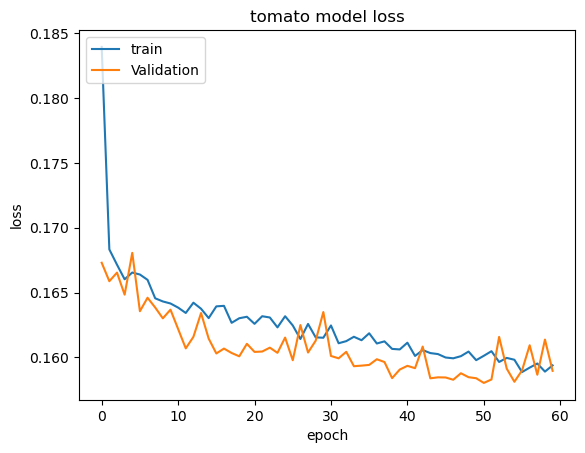

In [75]:
plt.plot(model_LSTM_trained.history['loss'])
plt.plot(model_LSTM_trained.history['val_loss'])
plt.title(f'{crop} model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [76]:
# Evaluate LSTM
loss_lstm = model_LSTM.evaluate(X_test, y_test, verbose=0)
y_pred_lstm = model_LSTM.predict(X_test, verbose=0)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = root_mean_squared_error(y_test,y_pred_lstm)

print(f"LSTM Loss (MAE): {loss_lstm}")
print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM Time: {train_t_LSTM}")

LSTM Loss (MAE): 0.1713905781507492
LSTM RMSE: 0.23474442878029622
LSTM Time: 104.54165506362915


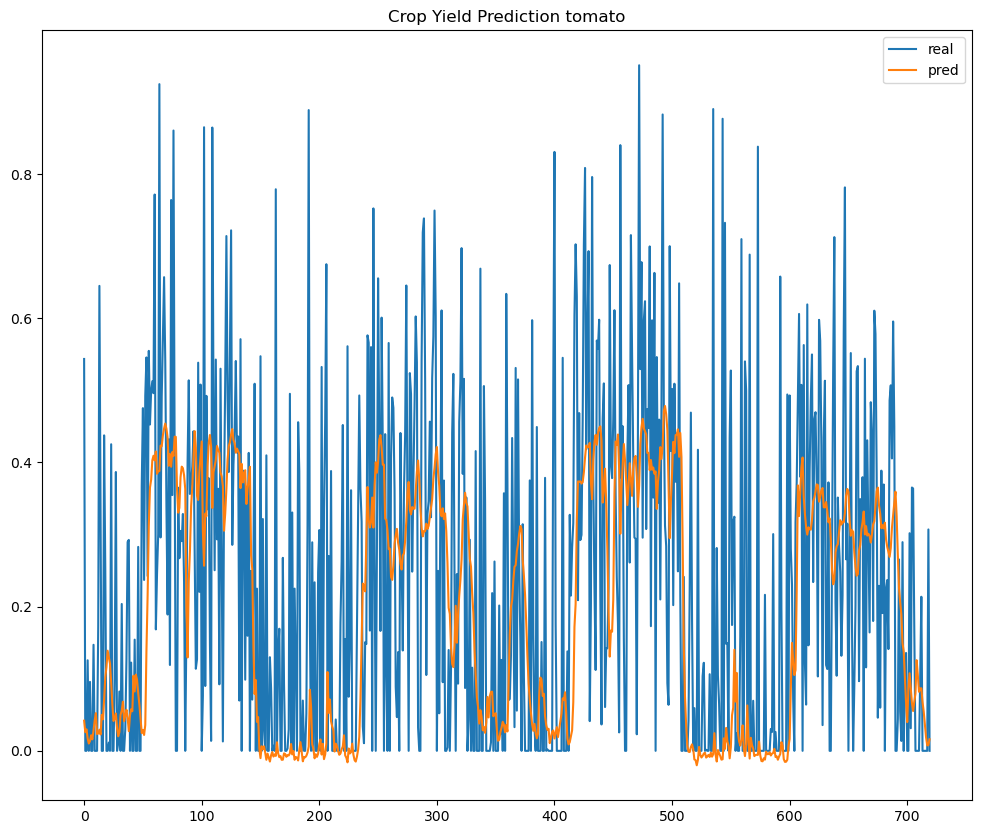

In [77]:
plt.figure(figsize=(12,10))
plt.plot(y_test,label="real")
plt.plot(y_pred_lstm,label="pred")
plt.title(f'Crop Yield Prediction {crop}')
plt.legend()

In [78]:
last_input = X_test[-10:]  # Get the last input from the test set
predictions = []
days = 365

for i in range(days):
    next_pred = model_LSTM.predict(last_input,verbose=0)
    predictions.append(next_pred[0][0])

    # Prepare next input: append the new prediction and shift the window 
    last_input = np.roll(last_input, -1)  # Shift left by 1
    last_input[-1] = next_pred  # Add new prediction at the end


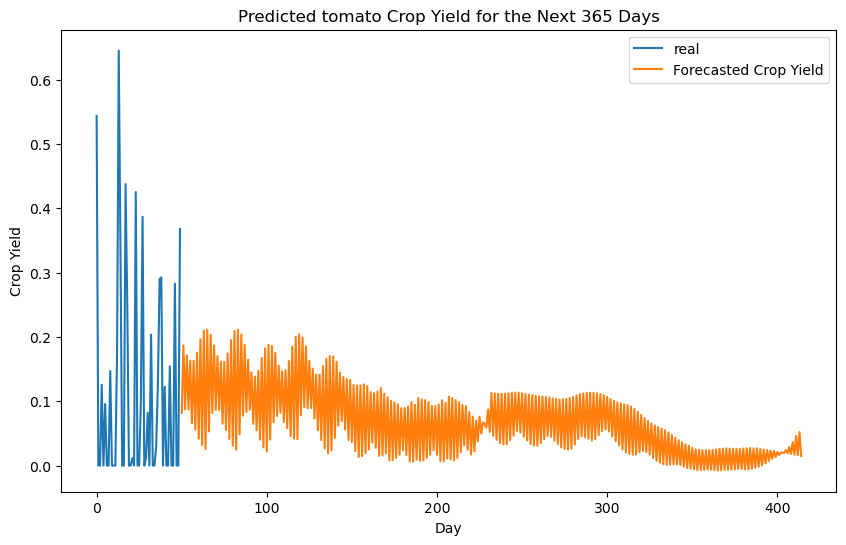

In [79]:
#Visualize the predicted crops for the next 365 days
real_days = 50
plt.figure(figsize=(10, 6))
plt.plot(range(real_days),y_test[:real_days],label='real')
plt.plot(range(real_days,real_days+days),predictions[:days], label='Forecasted Crop Yield')
plt.xlabel('Day')
plt.ylabel('Crop Yield')
plt.title(f'Predicted {crop} Crop Yield for the Next {days} Days')
plt.legend()
plt.show()